## Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors. 

Sorting seeds based on physical characteristics is critical in agriculture. Manual sorting is time-consuming and less accurate. Computer algorithms are used to analyze images of seeds and classify them based on features like size and shape, streamlining sorting speed, increasing accuracy, and decreasing manual labor.

Our project analyzes a dataset of digitized dry bean image features created by Koklu, M. and Ozakan, I.A. (Koklu and Ozakan, 2020). It contains 17 attributes and 13611 observations. Each row corresponds to an image of a dry bean, including information about its Class (target) and predictors. We’ll use K-nearest classification to predict classes of seeds.

Variables of interest:

1.) Area: Area of a bean zone and the number of pixels within its boundaries. 

2.) Perimeter: Bean circumference is defined as the length of its border. 

3.) Major axis length (L): Distance between the ends of the longest line that can be drawn from a bean. 

4.) Minor axis length (l): Longest line that can be drawn from the bean while standing perpendicular to the main axis. 

5.) Aspect ratio: Defines the relationship between L and l. 

6.) Eccentricity: Eccentricity of the ellipse having the same moments as the region. 

7.) Convex area: Number of pixels in the smallest convex polygon that can contain the area of a bean seed. 

8.) Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area. 

9.) Extent: The ratio of the pixels in the bounding box to the bean area. 

10.) Solidity: The ratio of the pixels in the convex shell to those found in beans.

11.) Roundness: Calculated as(4piA)/(P^2) 

12.) Compactness: Measures the roundness of an object, Ed/L 

13.) Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

unknowns:

14.)ShapeFactor1

15.)ShapeFactor2

16.)ShapeFactor3

17.)ShapeFactor4


#### Research Question: Can we utilize measurements of dry bean images to predict the class of an unknown bean (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz, or Sira)?

In [1]:
# Download all the necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("tableone")
library(tableone)
options(repr.matrix.max.rows = 6)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:

# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)|> mutate(Class=as_factor(Class))

# remove missing values if any
bean_data <- filter(bean_data, rowSums(is.na(bean_data)) != ncol(bean_data))




Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Spliting the data into training and testing set

In [3]:

#Set the seed. Don't remove this!
set.seed(3456) 

# Randomly split 50% of the data in the training set and 50% in test set. 
# This will be proportional to the different number of bean Classes in the dataset.

bean_split <- initial_split(bean_data, prop = 0.5, strata = Class)  
bean_train <- training(bean_split)   
bean_test <- testing(bean_split) # wont touch it until the best classifier is obtained

# your code here
bean_train
bean_test

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
47794,833.459,279.6546,217.9186,1.283298,0.6267232,48528,246.6844,0.7381313,0.9848747,0.8645991,0.8821041,0.005851248,0.002185283,0.7781077,0.9985444,BARBUNYA
47981,809.088,291.6540,210.0432,1.388543,0.6937880,48451,247.1666,0.7697775,0.9902995,0.9210594,0.8474651,0.006078530,0.001934041,0.7181971,0.9972476,BARBUNYA
49317,886.931,310.5631,202.4589,1.533956,0.7582971,50400,250.5840,0.7130856,0.9785119,0.7878197,0.8068700,0.006297282,0.001646445,0.6510392,0.9986656,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57790,920.668,360.9603,204.7025,1.763341,0.8236453,58342,271.2573,0.7359815,0.9905385,0.8567546,0.7514878,0.006246069,0.001228780,0.5647338,0.9958183,SIRA
57944,921.449,353.8206,210.4090,1.681585,0.8039647,59041,271.6185,0.6863532,0.9814197,0.8575821,0.7676727,0.006106252,0.001308154,0.5893215,0.9909941,SIRA
58074,910.115,351.9589,210.4178,1.672667,0.8016096,58609,271.9230,0.7776483,0.9908717,0.8810470,0.7725988,0.006060524,0.001332006,0.5969089,0.9984295,SIRA


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42042,771.515,288.0827,186.3471,1.545947,0.7626149,42476,231.3645,0.8162544,0.9897825,0.8875738,0.8031185,0.006852259,0.001758458,0.6449992,0.9971345,DERMASON
42049,770.185,290.1634,185.0517,1.568013,0.7702435,42503,231.3838,0.7560050,0.9893184,0.8907902,0.7974258,0.006900602,0.001721186,0.6358878,0.9970802,DERMASON
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON


Class,count
<fct>,<int>
BOMBAY,266
BARBUNYA,648
CALI,814
⋮,⋮
SEKER,1012
SIRA,1339
DERMASON,1762


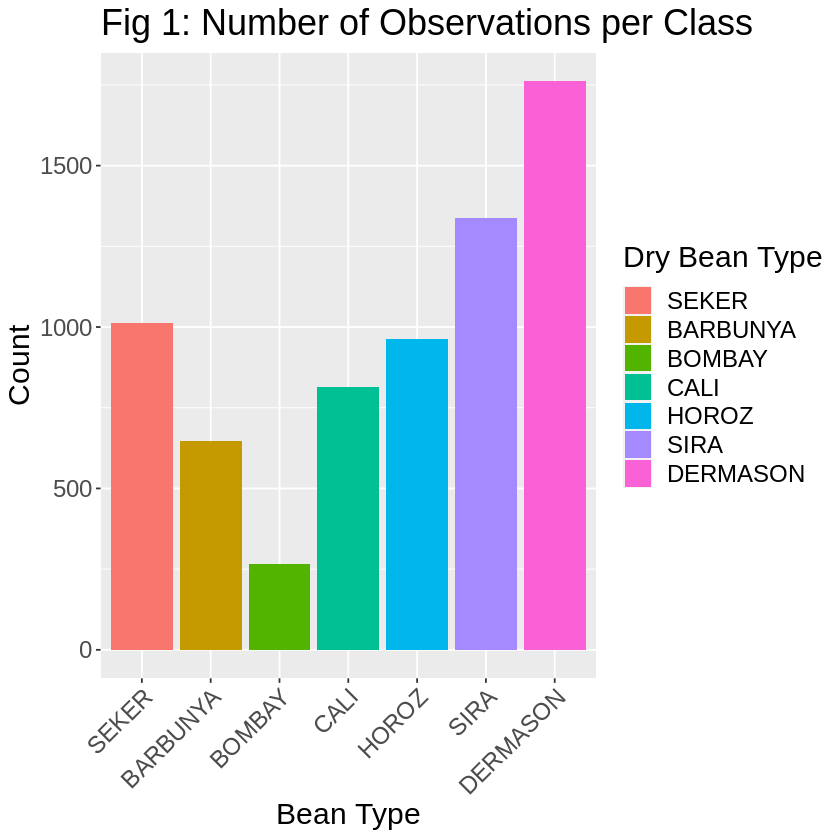

In [4]:
# Finding the number of observations in each Class 
bean_count <- bean_train|>
                    group_by(Class)|>
                    summarize(count = n())|>
                    arrange(count)
bean_count
bean_count_viz <- bean_count |>
    ggplot(aes(x= Class, y=count, fill=Class)) +
             geom_bar(stat = "identity") +
    labs(x = "Bean Type", y = "Count", fill="Dry Bean Type") +
     theme(text = element_text(size = 18)) +
    ggtitle("Fig 1: Number of Observations per Class")+
    theme(axis.text.x = element_text(angle=45, hjust =1))
    
    bean_count_viz



In Fig 1, we can observe that BOMBAY has the lowest number of observations and DERMASON has the highest.

### Selection of Predictors



We removed variables not explained in the dataset such as shape factors 1, 2, 3, and 4. Moreover, redundant attributes convey similar information i.e the aspect ratio is the relationship between the major and minor axis of a seed. Thus, major and minor axis lengths were removed due to redundancy. We’ll analyze overlapping distributions of histogram plots of each predictor for variable selection.  If distributions between different classes of beans overlapped significantly, it’s not a good predictor, while if distribution is spread out, with little overlap between the classes, it could be a good predictor. Perimeter and area are also redundant, so bean type distributions in Fig 2 and Fig 3 were compared to select between them. Fig 3 shows well-dispersed distributions between different classes, suggesting perimeter is a better predictor than area. Similarly, histograms for distribution of bean types for the variables extent, solidity, and convex area, show notable overlap, and were consequently removed. Ultimately, we chose perimeter, aspect ratio, eccentricity, equivalence diameter, roundness, and compactness as predictors.

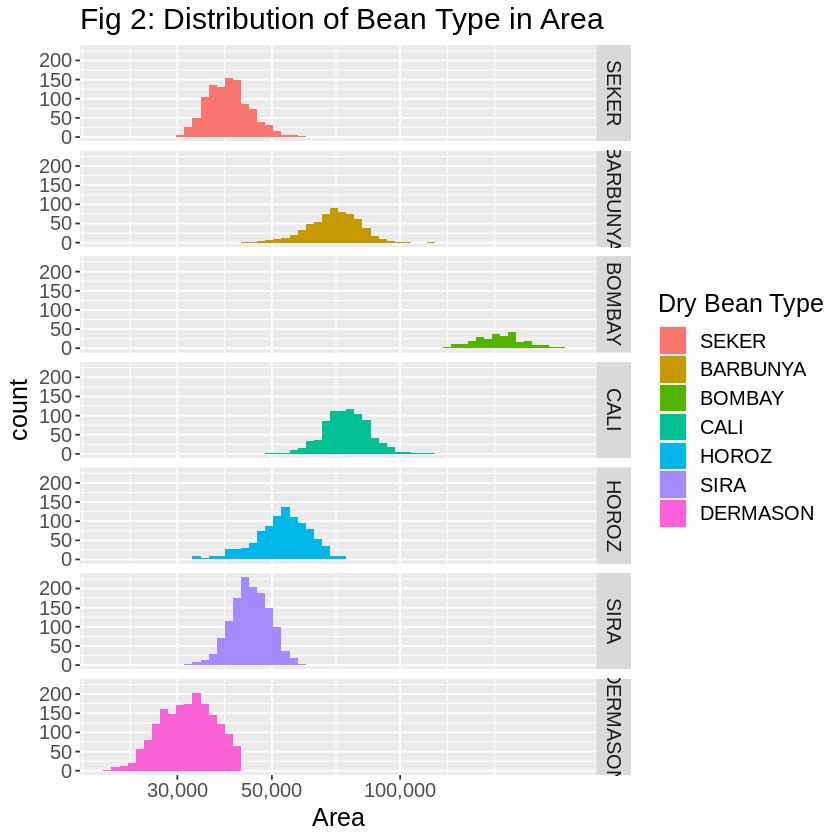

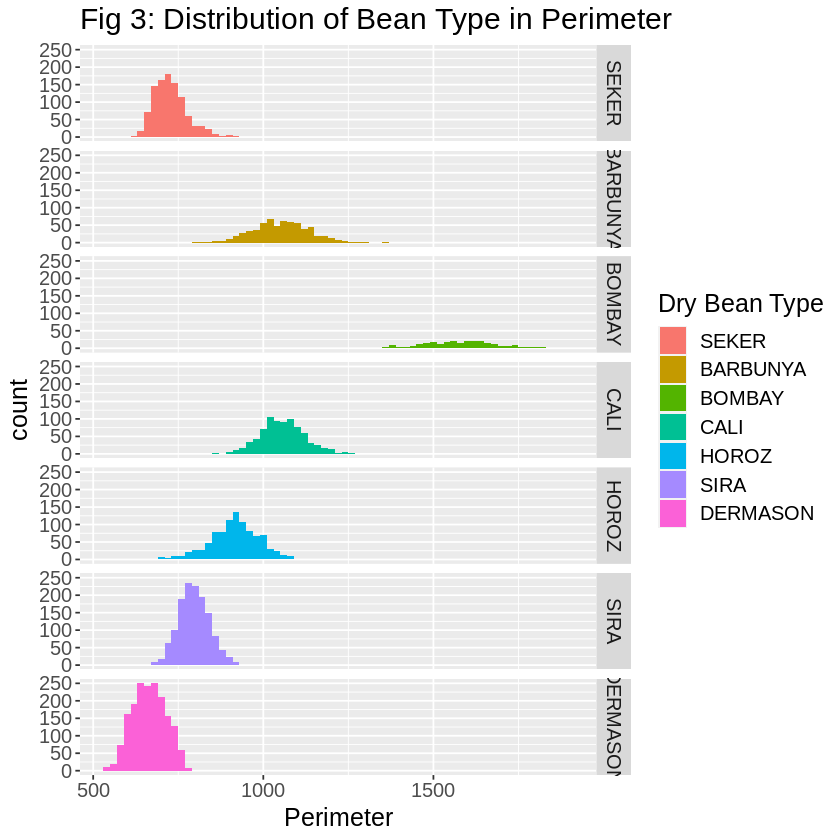

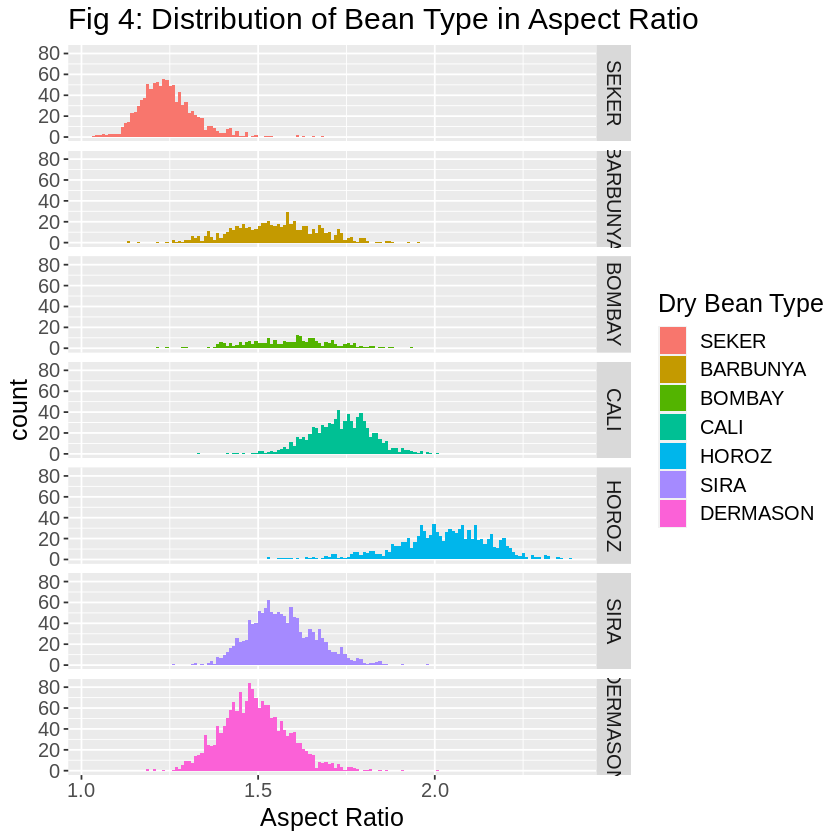

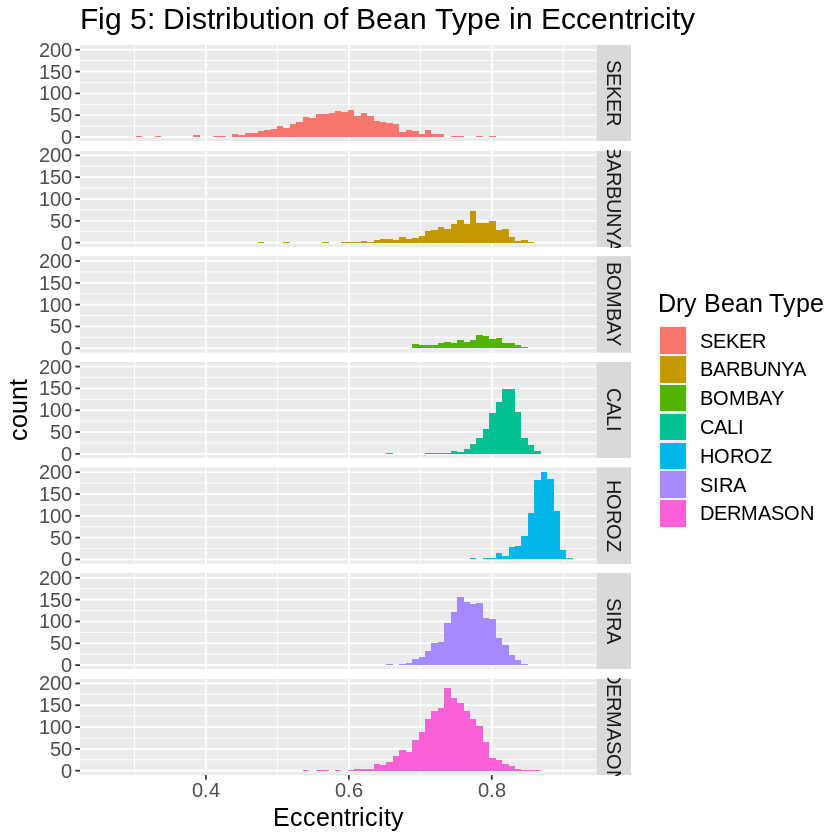

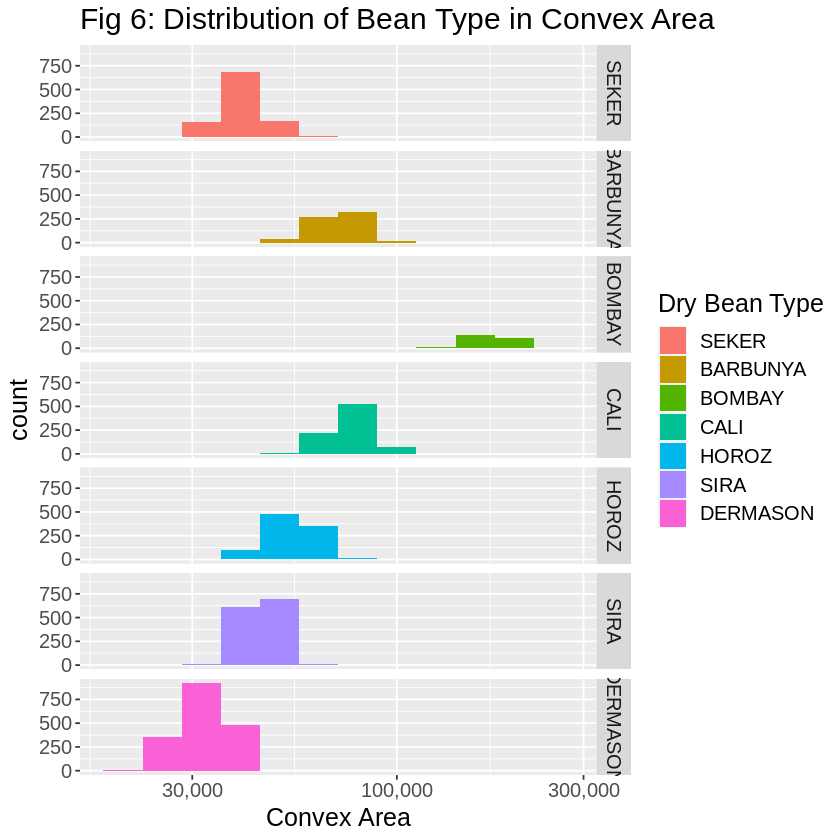

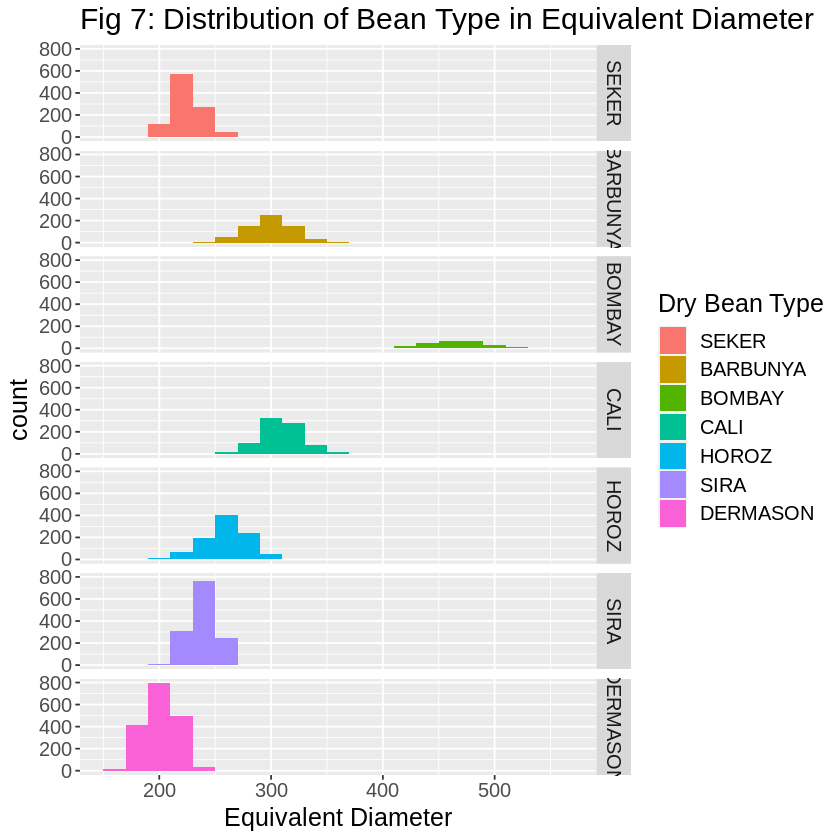

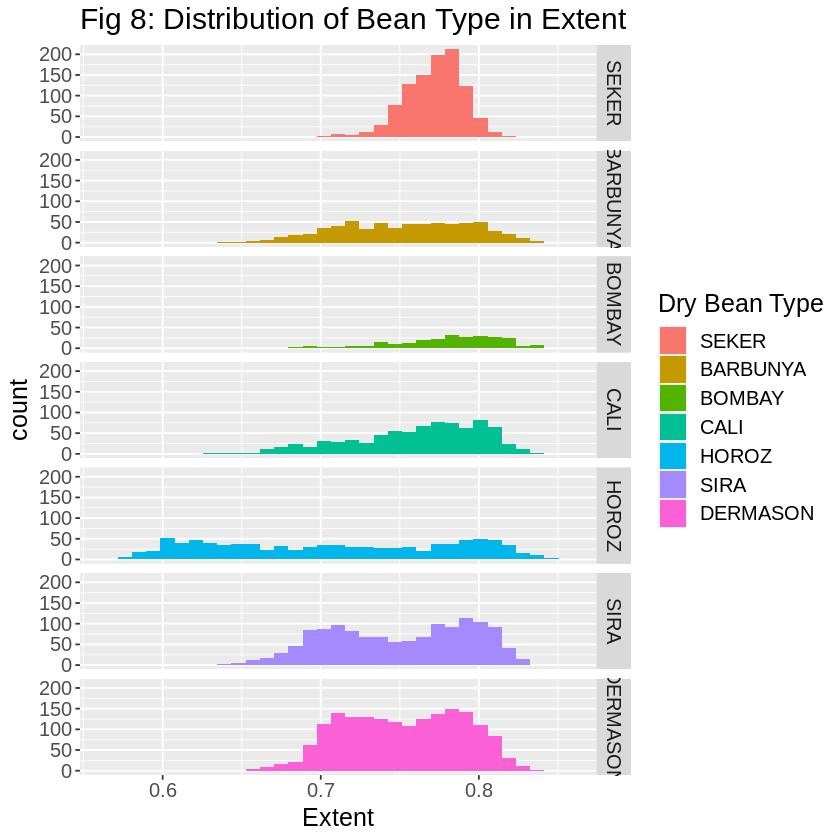

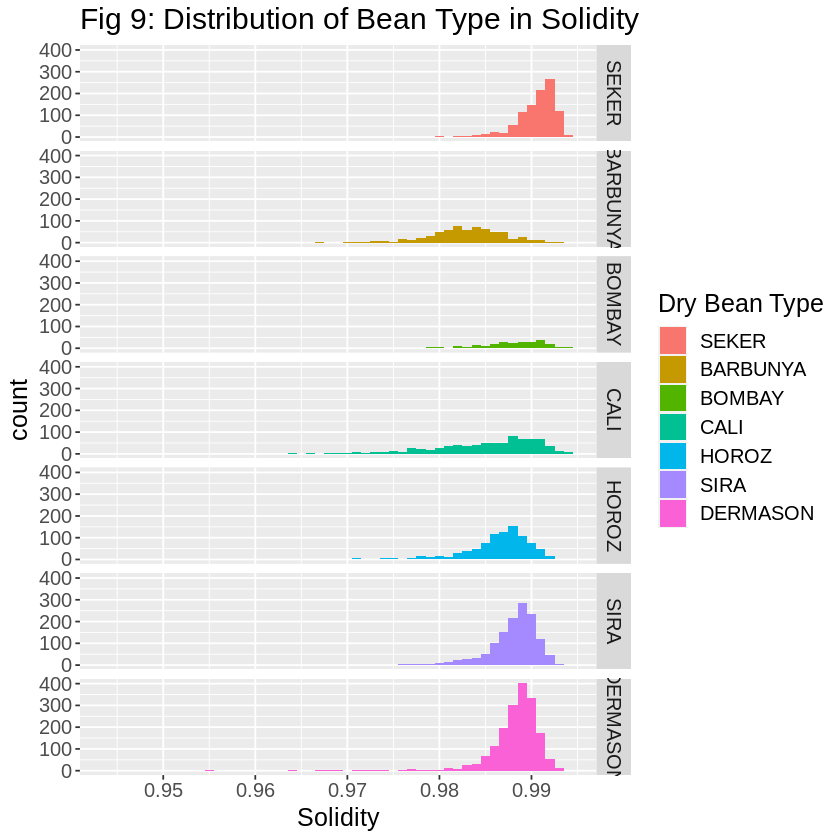

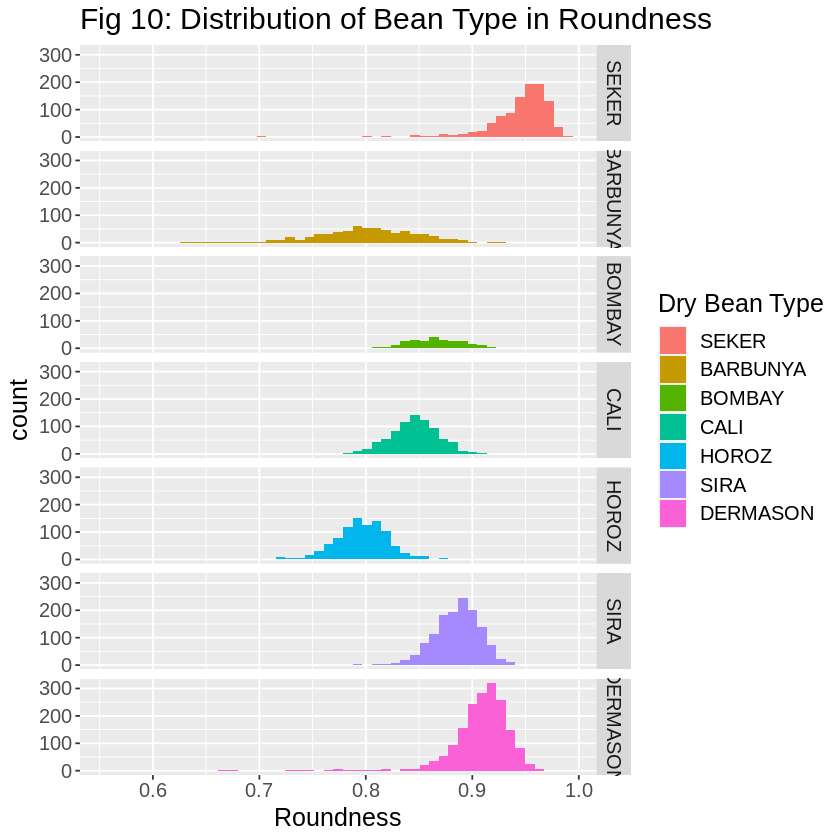

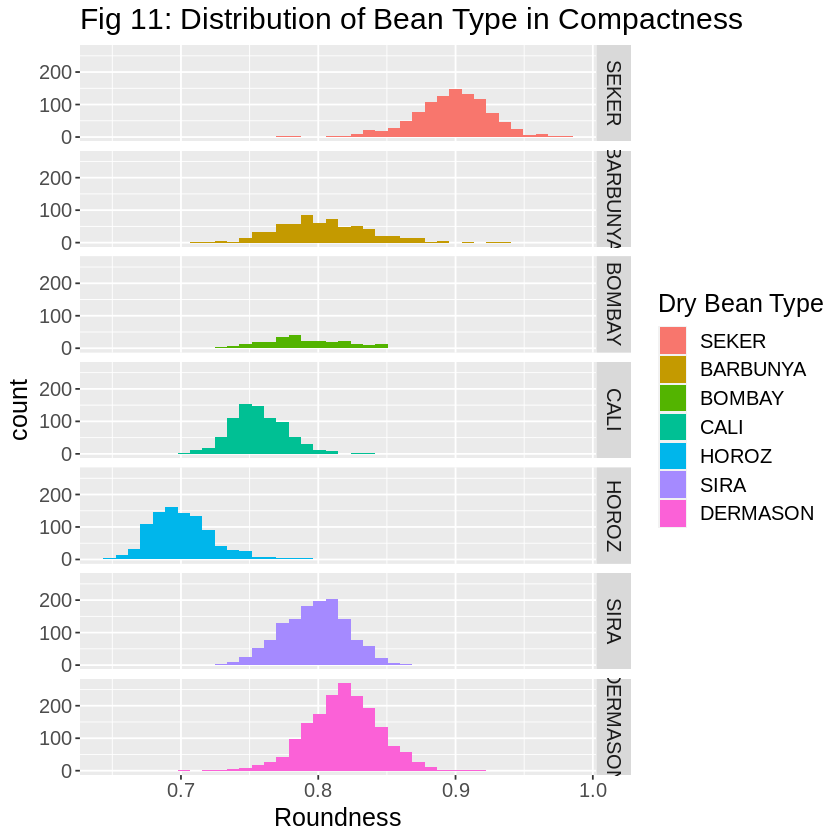

In [5]:

        
bean_area <- bean_train |> 
        ggplot(aes(x= Area, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.019) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Area", 
           fill = "Dry Bean Type") +
  scale_x_log10(labels = label_comma()) +
  ggtitle("Fig 2: Distribution of Bean Type in Area")

bean_perimeter <- bean_train |> 
        ggplot(aes(x= Perimeter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Perimeter", 
           fill = "Dry Bean Type") +
  ggtitle("Fig 3: Distribution of Bean Type in Perimeter")


bean_aspectration <- bean_train |> 
        ggplot(aes(x= AspectRation, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))  +
    labs(x = "Aspect Ratio", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 4: Distribution of Bean Type in Aspect Ratio")

bean_eccentricity <- bean_train |> 
        ggplot(aes(x= Eccentricity, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Eccentricity", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 5: Distribution of Bean Type in Eccentricity")

bean_convexarea <- bean_train |> 
        ggplot(aes(x= ConvexArea, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.1)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Convex Area", 
           fill = "Dry Bean Type")+
 scale_x_log10(labels = label_comma())+
  ggtitle("Fig 6: Distribution of Bean Type in Convex Area")

bean_equivdiameter <- bean_train |> 
        ggplot(aes(x= EquivDiameter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Equivalent Diameter", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 7: Distribution of Bean Type in Equivalent Diameter")

bean_extent <- bean_train |> 
        ggplot(aes(x= Extent, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Extent", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 8: Distribution of Bean Type in Extent")

bean_solidity <- bean_train |> 
        ggplot(aes(x= Solidity, fill = Class))+
        geom_histogram(position= "identity",binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Solidity", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 9: Distribution of Bean Type in Solidity")

bean_roundness <- bean_train |> 
        ggplot(aes(x= roundness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Roundness", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 10: Distribution of Bean Type in Roundness")

bean_compactness <- bean_train |> 
        ggplot(aes(x= Compactness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Roundness", 
           fill = "Dry Bean Type")+
  ggtitle("Fig 11: Distribution of Bean Type in Compactness")

        
bean_area
bean_perimeter 
bean_aspectration
bean_eccentricity
bean_convexarea
bean_equivdiameter
bean_extent
bean_solidity
bean_roundness
bean_compactness

# We also specify position = "identity" in geom_histogram to ensure the histograms for each experiment will be
# overlaid side-by-side, instead of stacked bars

## Summary Tables

In [6]:

# Table of mean for each predictor by Class
bean_mean <- bean_train|>
group_by(Class)|> summarise(mean_Perimeter = mean(Perimeter), 
                  mean_AspectRation = mean(AspectRation),
                  mean_Eccentricity = mean(Eccentricity),
                  mean_EquivDiameter = mean(EquivDiameter),
                  mean_roundness = mean(roundness),
                  mean_Compactness = mean(Compactness),
                  mean_ShapeFactor3 = mean(ShapeFactor3))
bean_mean

Class,mean_Perimeter,mean_AspectRation,mean_Eccentricity,mean_EquivDiameter,mean_roundness,mean_Compactness,mean_ShapeFactor3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEKER,727.3708,1.244729,0.5846684,224.8468,0.9445555,0.8969754,0.8053657
BARBUNYA,1051.0513,1.548376,0.7560652,298.6601,0.7996874,0.8039823,0.6475117
BOMBAY,1581.5547,1.590000,0.7715383,467.9070,0.8650496,0.7916662,0.6277486
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,916.4911,2.022805,0.8669873,259.8699,0.7949700,0.7014134,0.4925329
SIRA,796.6616,1.569933,0.7674133,238.4418,0.8848772,0.7973152,0.6362818
DERMASON,664.3769,1.492421,0.7375095,201.4896,0.9084326,0.8185607,0.6707270


This table displays the central tendency of each variable by class. For Perimeter and EquivDiameter, SEKER and SIRA have similar means while BOMBAY has the highest mean. For roundness, and compactness, HOROZ, CALI, and BOMBAY have similar means while SEKER has the highest mean. For AspectRatio and Eccentricity, SEKER, DERMASON, and BARBUNYA have similar means while HOROZ has the highest mean.

In [7]:
# Table of standard deviation for each predictor by Class
bean_sd <- bean_train|>
group_by(Class)|>
summarise(sd_Perimeter = sd(Perimeter), 
          sd_AspectRation = sd(AspectRation),
          sd_Eccentricity = sd(Eccentricity),
          sd_EquivDiameter = sd(EquivDiameter),
          sd_roundness = sd(roundness),
          sd_Compactness = sd(Compactness),
          sd_ShapeFactor3 = sd(ShapeFactor3))
bean_sd

Class,sd_Perimeter,sd_AspectRation,sd_Eccentricity,sd_EquivDiameter,sd_roundness,sd_Compactness,sd_ShapeFactor3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEKER,48.27273,0.08104768,0.07046555,13.28565,0.03329497,0.02831256,0.05040102
BARBUNYA,84.22283,0.12682530,0.05030598,20.69337,0.04832042,0.03355516,0.05449127
BOMBAY,112.26054,0.12268589,0.04322571,30.27300,0.02720218,0.03189207,0.05092375
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,72.74546,0.13440808,0.02112551,18.85488,0.03037517,0.02351011,0.03350037
SIRA,44.31134,0.09435706,0.03179027,12.13902,0.02316909,0.02388917,0.03803259
DERMASON,49.28234,0.09624494,0.03975075,14.59623,0.02720078,0.02618955,0.04283711


The above table gives an idea about variation from the mean of each variable by its class.

In [8]:

# Train data after the selected predictors
bean_train <- bean_train|>
                        select(Perimeter, AspectRation, Eccentricity, EquivDiameter, roundness, Compactness, Class)
# General summary Statistics of the data set. Predictor means, median, Max and Min

bean_train$Class <- factor(bean_train$Class, levels=c("BARBUNYA", "BOMBAY", "CALI", "DERMASON", "HOROZ", "SEKER", "SIRA"))
summary(bean_train )

############## Tableone package ###############
#summary Statistics of the data set. Predictor means, median, standard deviation, skewness, Kurtosis, Max, Min ...

CreateTableOne(data=bean_train) # descriptive table for the entire dataset
table_detail <- CreateTableOne(data=bean_train)
summary(table_detail)

   Perimeter       AspectRation    Eccentricity    EquivDiameter  
 Min.   : 530.8   Min.   :1.036   Min.   :0.2628   Min.   :162.7  
 1st Qu.: 702.8   1st Qu.:1.434   1st Qu.:0.7169   1st Qu.:214.7  
 Median : 794.0   Median :1.552   Median :0.7647   Median :238.1  
 Mean   : 855.0   Mean   :1.584   Mean   :0.7513   Mean   :253.0  
 3rd Qu.: 977.8   3rd Qu.:1.710   3rd Qu.:0.8111   3rd Qu.:279.9  
 Max.   :1895.9   Max.   :2.389   Max.   :0.9082   Max.   :562.4  
                                                                  
   roundness       Compactness          Class     
 Min.   :0.5568   Min.   :0.6454   BARBUNYA: 648  
 1st Qu.:0.8329   1st Qu.:0.7617   BOMBAY  : 266  
 Median :0.8836   Median :0.8011   CALI    : 814  
 Mean   :0.8735   Mean   :0.7996   DERMASON:1762  
 3rd Qu.:0.9166   3rd Qu.:0.8336   HOROZ   : 963  
 Max.   :0.9879   Max.   :0.9816   SEKER   :1012  
                                   SIRA    :1339  

                           
                            Overall        
  n                           6804         
  Perimeter (mean (SD))     855.02 (214.44)
  AspectRation (mean (SD))    1.58 (0.25)  
  Eccentricity (mean (SD))    0.75 (0.09)  
  EquivDiameter (mean (SD)) 253.03 (59.26) 
  roundness (mean (SD))       0.87 (0.06)  
  Compactness (mean (SD))     0.80 (0.06)  
  Class (%)                                
     BARBUNYA                  648 ( 9.5)  
     BOMBAY                    266 ( 3.9)  
     CALI                      814 (12.0)  
     DERMASON                 1762 (25.9)  
     HOROZ                     963 (14.2)  
     SEKER                    1012 (14.9)  
     SIRA                     1339 (19.7)  


     ### Summary of continuous variables ###

strata: Overall
                 n miss p.miss  mean    sd median   p25   p75   min   max  skew
Perimeter     6804    0      0 855.0 2e+02  794.0 702.8 977.8 530.8 2e+03  1.62
AspectRation  6804    0      0   1.6 2e-01    1.6   1.4   1.7   1.0 2e+00  0.56
Eccentricity  6804    0      0   0.8 9e-02    0.8   0.7   0.8   0.3 9e-01 -1.08
EquivDiameter 6804    0      0 253.0 6e+01  238.1 214.7 279.9 162.7 6e+02  1.94
roundness     6804    0      0   0.9 6e-02    0.9   0.8   0.9   0.6 1e+00 -0.59
Compactness   6804    0      0   0.8 6e-02    0.8   0.8   0.8   0.6 1e+00  0.05
               kurt
Perimeter      3.50
AspectRation   0.09
Eccentricity   1.44
EquivDiameter  5.09
roundness      0.16
Compactness   -0.22


     ### Summary of categorical variables ### 

strata: Overall
   var    n miss p.miss    level freq percent cum.percent
 Class 6804    0    0.0 BARBUNYA  648     9.5         9.5
                          BOMBAY  266     3.9        13

### Forward selection
At this stage, we compared the accuracies of models that use different combinations of the six chosen predictors. The best model has Perimeter, Compactness, roundness, Eccentricity, EquivDiameter, and AspectRation as the predictors with 91.4% accuracy. 

In [9]:

# select all columns (possible predictors) except Class
names <- colnames(bean_train |> select (-Class))

# Make model formula for all predictors
model_formula <- paste("Class", "~", paste(names, collapse="+"))
model_formula 

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
BeanData_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

[1] "Class ~ Perimeter+AspectRation+Eccentricity+EquivDiameter+roundness+Compactness"

In [ ]:
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        BeanData_recipe <- recipe(as.formula(model_string), 
                                data = bean_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe( BeanData_recipe ) |>
          add_model(knn_spec) |>
          tune_grid(resamples = BeanData_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

### Visualizing Results
One way to visualize model accuracy is scatterplots. Each bean is a data point plotted against the x-axis representing the actual class and the y-axis representing the predicted class. If our model is accurate, we expect data points to align diagonally following the equation y=x. However, with misclassifications, the trend will be distorted.


### Expected Outcomes and Significance

We expected the most accurate model to have the highest number of predictors. However, by including redundant variables, accuracy of our model decreased. Therefore, we selected 6 relevant predictors for our k-NN classification model. 
Findings from this study have significant implications for the agricultural industry, as development of automated image classification technology can improve efficiency and accuracy of dry bean sorting, reducing labor costs. Success could lead to research on applications of image classification models to other agricultural products (e.g., crops and fruits), or examining socio-economic impacts of this technology via agriculture, specifically potential for job displacement.